# Performance tests

* [This Coral TPU project](https://github.com/foobar167/junkyard/tree/master/coral_tpu)

Useful links:
* [TensorFlow models on the Edge TPU](https://coral.ai/docs/edgetpu/models-intro/#compatibility-overview)
* [Colab tutorials for Coral](https://github.com/google-coral/tutorials)
* [Retrain MobileNet V2 classifier for the Edge TPU (TF2)](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb)

## Helper functions

In [9]:
import os
import math
import json
import shutil
import zipfile
import tarfile
import platform

from PIL import Image
# from IPython.display import display
from matplotlib import pyplot as plt


def extract(fname):
    """ Extract data from archive file """
    if fname.endswith(".tar.gz") or fname.endswith(".tgz"):
        ref = tarfile.open(fname, mode="r:gz")
    elif fname.endswith(".tar"):
        ref = tarfile.open(fname, mode="r:")
    elif fname.endswith(".tar.bz2") or fname.endswith(".tbz"):
        ref = tarfile.open(fname, mode="r:bz2")
    elif fname.endswith(".zip"):
        ref = zipfile.ZipFile(fname, mode="r")
    ref.extractall()
    ref.close()


def tgz(sdir):
    """ Make *.tgz archive file from source dir """
    sdir = sdir.strip("\\/")  # remove all leading and trailing slashes
    fname = os.path.basename(sdir)
    fname_tgz = fname + ".tgz"
    fname_tar_gz = fname + ".tar.gz"
    archive1 = os.path.join(os.path.dirname(sdir), fname_tgz)
    archive2 = os.path.join(os.path.dirname(sdir), fname_tar_gz)
    # Delete dir or file if exists
    if os.path.exists(archive1) and os.path.isdir(archive1):
        shutil.rmtree(archive1, ignore_errors=False)
    elif os.path.exists(archive1) and os.path.isfile(archive1):
        os.remove(archive1)
    # Make *.tag.gz file
    with tarfile.open(fname_tar_gz, "w:gz") as tar:
        tar.add(sdir, arcname=fname)
    # Reaneme *.tar.gz to *.tgz
    os.rename(archive2, archive1)


EXT = (".jpg", ".jpeg", ".png", ".gif")  # valid image file extensions


def separator(info=""):
    """ Separator string with information """
    sep1 = "-"
    sep2 = " "
    sep_length = 70  # separator length
    l1 = (sep_length - len(info)) // 2 - len(sep2)  # number of dashes
    if len(info) == 0:
        s = sep1 * sep_length
        return f"{s}"
    elif l1 <= 0:
        return info
    else:
        l2 = (sep_length - len(info)) % 2  # 0 or 1 extra space
        s1 = sep1 * l1
        s2 = info + " " * l2
        return f"{s1}{sep2}{s2}{sep2}{s1}"


def get_image_names(path):
    """ Get all image names in a directory """
    names = []
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            names.append(f)
    return names


def get_image_names2(path):
    """ Get all image names in a directory and
        return the list of (label, name) """
    dataset = []  # list of (label, name)
    classes = {}  # dict of classes
    for root, dirs, files in os.walk(path, topdown=True):
        for name in files:
            if name.lower().endswith(EXT):
                label = os.path.basename(root)
                name = os.path.join(root, name)
                dataset.append((int(label), name))
                classes[label] = label
    return dataset, classes


def get_images(path):
    """ Get all images in a directory """
    images = {}
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            images[f] = Image.open(os.path.join(path, f)).convert("RGB")
    return images


def get_images2(lst):
    """ Get all images from the list (label, name) and
        return dictoonary of images """
    images = {}
    for label, name in lst:
        if name.lower().endswith(EXT):
            images[name] = Image.open(name).convert("RGB")
    return images


# def show(images, cmap="viridis"):
#     """ Show images with matplotlib. Default color map is "viridis" """
#     for key, value in images.items():
#         value = value.resize((100, 100))
#         display(value)


def show(images, cmap="viridis"):
    """ Show images with matplotlib. Default color map is "viridis" """
    fig = plt.figure(figsize=(12, 8))  # create figure
    l = len(images)
    rows = math.floor(math.sqrt(l))
    cols = math.ceil(l / rows)
    for i, (key, value) in enumerate(images.items(), 1):
        fig.add_subplot(rows, cols, i)  # add a subplot
        plt.imshow(value, cmap=cmap); plt.axis("off"); plt.title(key)
    plt.show()


def load_labels(idx=1):
    """ Get ImageNet dataset labels from URL """
    url = "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/imagenet_class_index.json"
    name = os.path.basename(url)
    if not os.path.exists(name):
        output = os.system(f"wget {url} -O {name}")
        if output != 0:
            print(f"Error when downloading URL: {url}")
            return None
    CLASS_INDEX = json.load(open(name))
    labels = []
    for i in range(len(CLASS_INDEX)):
        # CLASS_INDEX example: "753": ["n04040759", "radiator"]
        labels.append(CLASS_INDEX[str(i)][idx])
    return labels


_INFO = {
    "Linux": "lscpu | grep 'Model name:'",
    "Windows": "wmic cpu get name, numberofcores",
}[platform.system()]


print(separator("CPU info"))
print(os.popen(cmd=_INFO).read())  # get info about the hardware (CPU)

------------------------------ CPU info ------------------------------
Name                                      NumberOfCores  

Intel(R) Core(TM) i5-2410M CPU @ 2.30GHz  2              






## Classify with different models

Take different neural network architectures for [ImageNet](https://www.image-net.org/) from TF repository: [Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

cat.jpg
human.jpg
panda.jpg
parrot.jpg


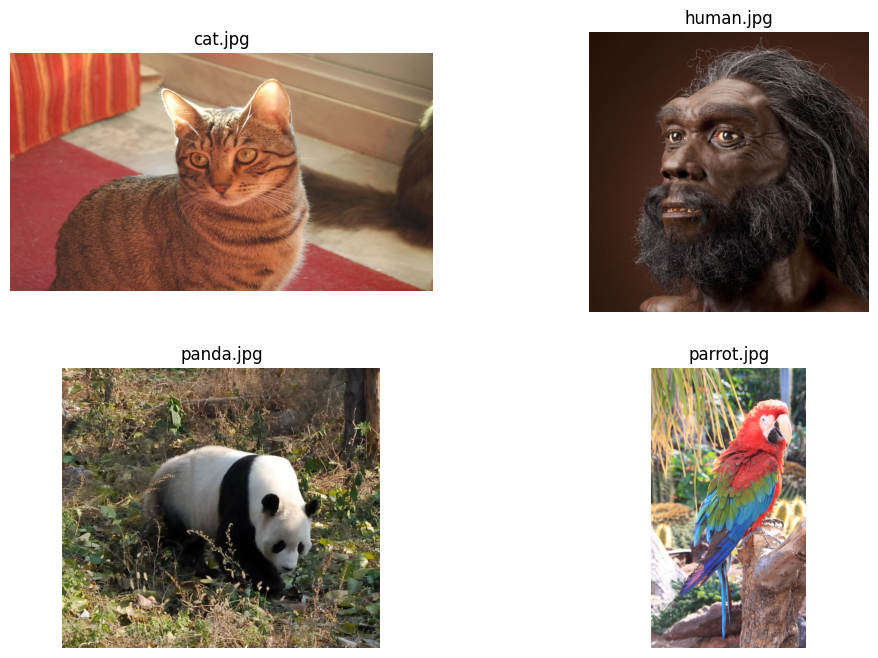

In [13]:
# Import necessary libraries
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.applications as apps

from IPython.display import display
# from tensorflow.keras.saving import save_model, load_model
from tensorflow.keras.models import save_model, load_model


# Create "temp" directory and make it the current dir
TEMP_DIR = "temp"
THIS_DIR = os.path.dirname(os.path.realpath("__file__"))  # path to the current dir
if os.path.basename(THIS_DIR) == TEMP_DIR:  # already in the "temp" directory
    pass
else:
    if not os.path.isdir(TEMP_DIR):  # directory does not exist
        os.makedirs(TEMP_DIR)
    os.chdir(os.path.join(THIS_DIR, TEMP_DIR))  # make path to "temp" dir the current path


# Download test images and show them
urls = {"parrot.jpg": "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/parrot.jpg",
        "cat.jpg":    "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/cat.jpg",
        "panda.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/panda.jpg",
        "human.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/human.jpg",
}
img_paths = []
for name, url in urls.items():
    output = os.system(f"wget {url} -O {name}")
    if output == 0:
        img_paths.append(name)
    else:
        print(f"Error when downloading URL: {url}")
print("\n".join(get_image_names(".")))  # print image names
show(get_images("."))  # show images


# Set constants
BATCH_SIZE = 100
IMAGE_SHAPE = (224, 224, 3)  # do not change it
IMAGE_SHAPE2 = (299, 299, 3)  # do not change it
RESIZE_METHOD = Image.BILINEAR
# RESIZE_METHOD2 = tf.image.ResizeMethod.BILINEAR
RESIZE_METHOD2 = tf.compat.v1.image.ResizeMethod.BILINEAR
BENCHMARK_IMG = "parrot.jpg"
COUNT = 22  # number of runs for benchmark
TOP_K = 3  # get first top results
OPTIMIZER = "rmsprop"
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
METRICS = ["accuracy"]
IMAGENETV2_PATH = "imagenetv2-matched-frequency-format-val"  # path to ImageNet-v2 dataset


# Models dictionary in the format: key: [name, "", norm, shape]
net = {
    "MobileNetV2": ["mobilenetv2_1.0_224",  # v[0] model filename
                    "placeholder",          # v[1] placeholder for variables
                    True,                   # v[2] normalize image or not
                    IMAGE_SHAPE],           # v[3] input image shape
    # "MobileNetV3Large": ["mobilenetv3large_1.0_224", "placeholder", False, IMAGE_SHAPE],
    # "MobileNetV3Small": ["mobilenetv3small_1.0_224", "placeholder", False, IMAGE_SHAPE],
    # "DenseNet121": ["densenet121_224", "placeholder", True, IMAGE_SHAPE],
    # "InceptionV3": ["inceptionv3_299", "placeholder", True, IMAGE_SHAPE2],
    # "ResNet50": ["resnet50_224", "placeholder", False, IMAGE_SHAPE],    # norm==False, check it for diff. TF
    # "ResNet101": ["resnet101_224", "placeholder", False, IMAGE_SHAPE],  # norm==False, check it for diff. TF
    # "ResNet50V2": ["resnet50v2_224", "placeholder", True, IMAGE_SHAPE],
    # "ResNet101V2": ["resnet101v2_224", "placeholder", True, IMAGE_SHAPE],
    # "VGG16": ["vgg16_224", "placeholder", False, IMAGE_SHAPE],          # norm==False, check it for diff. TF
    # "Xception": ["xception_299", "placeholder", True, IMAGE_SHAPE2],
}

## Unzip and prepare archive with models
Unzip and prepare archive with models from the previous step called
"[Get data for tests](https://colab.research.google.com/drive/1YLFMUxzHETAuOK69X_YQ_ei913W5cTMo)".

File "all_files.zip" should be in the "data" subfolder.
Change path to your archive with model files if necessary.

In [3]:
# %%script echo "Skip this cell"
extract("../data/all_files.zip")  # extract from "*.zip" archive

## Run speed benchmarks for TF

In [3]:
def preprocess_input(img_path, normalize, im_shape):
    """ Preprocess input. Analogue of
        "tf.keras.applications.mobilenet_v*.preprocess_input" function """
    img = Image.open(img_path).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.asarray(img)  # convert from PIL Image to NumPy
    if normalize:  # normalize image
        img = img / 127.5 - 1.0
    else:  # don't normalize image
        pass
    img = np.expand_dims(img, axis=0)  # (224,224,3) to (1,224,224,3)
    return img


def decode_predictions(results):
    """ Decode predictions. Analogue of
        "tf.keras.applications.mobilenet_v*.decode_predictions" function """
    labels = load_labels()
    top = results.argsort()[-TOP_K:][::-1]  # get first top k results
    # Return list of tuples (label, probability)
    return [(labels[i], f"{results[i]:.4f}") for i in top]


def average_runtime(runtime):
    """ Show average runtime """
    if len(runtime) > 5:
        runtime = runtime[2:]  # skip the first 2 values
    elif len(runtime) > 1:
        runtime = runtime[1:]  # skip the 1st value
    average = f"{np.average(runtime):>6.1f} ms"
    print(f"Average time of the last {len(runtime)} runs: {average}")
    return average


def run_unconverted(img_path, model_name, normalize, im_shape, unpack=True):
    """ Run unconverted TF model for image """
    path = os.path.join(TEMP_DIR, model_name)
    if unpack:
        extract(path + ".tgz")  # extract from "*.tgz" archive
    # Should be "compile=False" for different TF versions
    # model = tf.keras.layers.TFSMLayer(model_name, call_endpoint="serving_default")  # Keras3
    model = load_model(model_name, compile=False)  # not supported in Keras3
    # Set optimizer, loss and metrics for evaluation if necessary
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    print(separator("INFERENCE TIME"))
    img = preprocess_input(img_path, normalize, im_shape)  # preprocess image
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        model(img, training=False)  # predict
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")
    print(separator("RESULTS"))
    results = model(img, training=False)  # predict
    del model
    results = results.numpy()[0]  # convert from tf to numpy
    print(decode_predictions(results))
    return average_runtime(runtime)


def benchmark(img_path, run):
    """ Run benchmarks """
    for k, v in net.items():
        print(f"\n{separator(v[0])}\n")
        v[1] = run(img_path=img_path, model_name=v[0], normalize=v[2], im_shape=v[3])

    print(f"\n" f"Speeds for '{img_path}' image are:")
    for k, v in net.items():
        print(f"{k:17} {v[1]}")

In [4]:
benchmark(BENCHMARK_IMG, run_unconverted)


---------------------------- resnet50_224 ----------------------------





--------------------------- INFERENCE TIME ---------------------------
652.9 ms
581.6 ms
490.7 ms
449.7 ms
440.7 ms
503.7 ms
462.7 ms
556.7 ms
574.6 ms
629.6 ms
502.7 ms
483.7 ms
439.7 ms
490.7 ms
468.7 ms
466.7 ms
447.7 ms
554.7 ms
492.7 ms
557.7 ms
517.7 ms
478.7 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9642'), ('lorikeet', '0.0311'), ('toucan', '0.0009')]
Average time of the last 20 runs:  500.5 ms

Speeds for 'parrot.jpg' image are:
ResNet50           500.5 ms


## Download the ImageNet-v2 dataset
Download the [ImageNet-v2](https://www.tensorflow.org/datasets/catalog/imagenet_v2) dataset manually
to make performance tests for CPU and TPU uniform.

(0, 'imagenetv2-matched-frequency-format-val\\0\\58fbc3e79ef15162b7726de04e98c90bb91a3055.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\64f661b97cfd6db73bd6c30325597cf7c7b322d5.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\66123ec1b806abff544bb89e11653ef5185af4be.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\7e4a8987a9a330189cc38c4098b1c57ac301713f.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\8e1374a4e20d7af22665b7749158b7eb9fa3826e.jpeg')
(0, 'imagenetv2-matched-frequency-format-val\\0\\bcf8a5326180b5e9320642f5024096fbc8a5d454.jpeg')


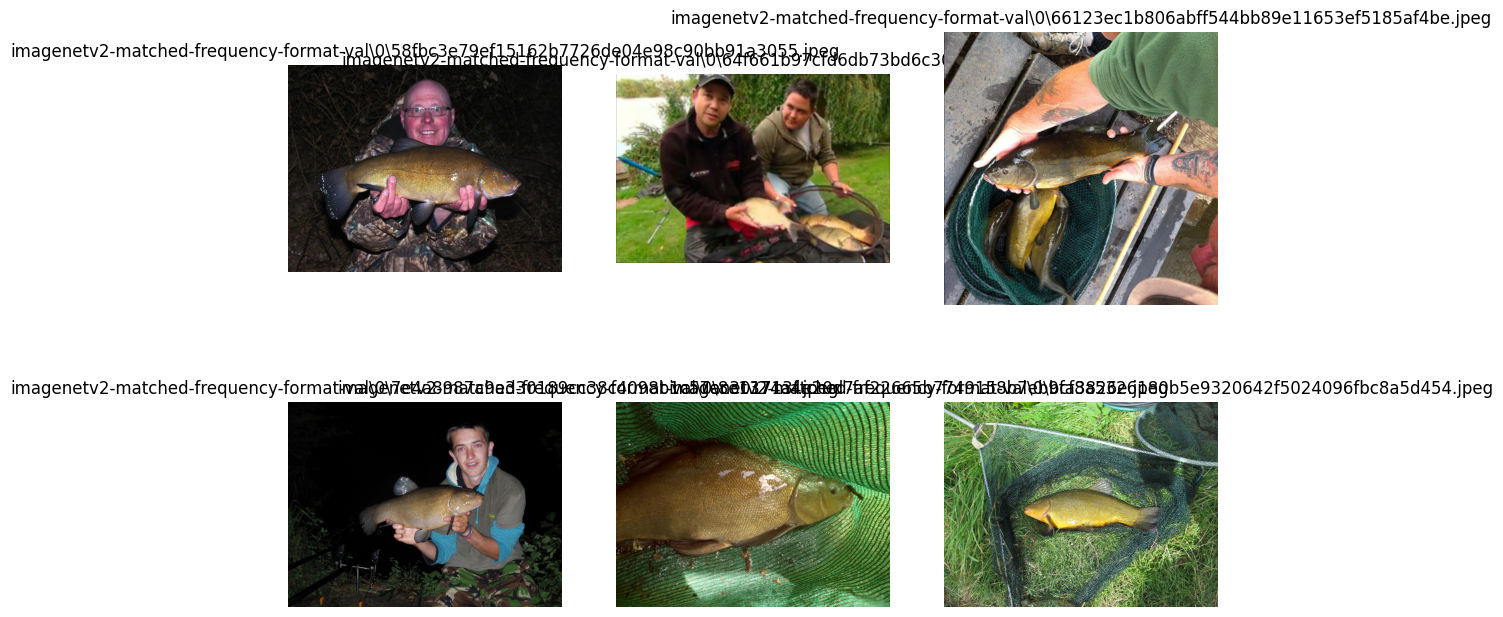

Number of classes: 1000
Number of images: 10000


In [10]:
# # %%script echo "Skip this cell"
# # Download ImageNet-v2 dataset
# DS, info = tfds.load(
#     "imagenet_v2", split="test", with_info=True,
#     # shuffle_files=True,
#     shuffle_files=False,
# )

# # Obtaining dataset information.
# print(f"Number of classes: {info.features['label'].num_classes}")
# # print(f"Classes: {info.features['label'].names}")
# print(f"Number of images: {len(DS)}")

# # Visualize dataset images. Can show only <= 9 images
# _ = tfds.show_examples(DS.take(12), info)


# Prepare the ImageNet-v2 dataset manually without TF
DS, CLASSES = get_image_names2(IMAGENETV2_PATH)

example = DS[:6]
print(*example, sep="\n")
imgs = get_images2(example)
show(imgs)  # visualize dataset images
print(f"Number of classes: {len(CLASSES)}")
print(f"Number of images: {len(DS)}")

## Run speed benchmarks for TF Lite

In [14]:
def run_converted(img_path, model_name, normalize, im_shape, ext=".tflite"):
    """ Run converted TF Lite model for image """
    model_name += ext  # use "*.tflite" files
    print(model_name)

    interpreter = tf.lite.Interpreter(model_path=os.path.join(TEMP_DIR, model_name))
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    height = input_details["shape"][1]  # NxHxWxC or [1, 224, 224, 3], H:1, W:2
    width = input_details["shape"][2]
    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    norm, mean = 127.5, 127.5
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # Image data must go through two transforms before running inference:
    #     1. normalization: f = (input - mean) / norm
    #     2. quantization: q = f / scale + zero_point
    # The following code combines the two steps as such:
    #     q = (input - mean) / (norm * scale) + zero_point
    #
    # However, if norm * scale equals 1, and mean - zero_point equals 0, the input
    #   does not need any preprocessing (but in practice, even if the results are
    #   very close to 1 and 0, it is probably okay to skip preprocessing for better
    #   efficiency; we use 1e-5 below instead of absolute zero).
    #
    # There are following options:
    #   | No. | Normalization | Quantization | Details          |
    #   | --- | ------------- | ------------ | ---------------- |
    #   | 1   | yes           | no           |                  |
    #   | 2   | no            | no           |                  |
    #   | 3   | no            | yes          |                  |
    #   | 4   | yes           | yes          | No preprocessing |
    #   | 5   | yes           | yes          |                  |
    img = Image.open(img_path).resize((width, height), RESIZE_METHOD)
    # 1. Normalization - yes. Quantization - no.
    if normalize and (scale.size == 0 or zero_point.size == 0):
        print("- 1 -")
        img = (np.asarray(img) - mean) / norm
    # 2. Normalization - no. Quantization - no.
    elif (not normalize) and (scale.size == 0 or zero_point.size == 0):
        print("- 2 -")
        pass
    # 3. Normalization - no. Quantization - yes.
    elif (not normalize):
        print("- 3 -")
        img = np.asarray(img) / scale + zero_point
    # 4. Norm - yes. Quant - yes. No preprocessing.
    elif abs(scale * norm - 1) < 1e-5 and abs(int(mean) - zero_point) < 1e-5:
        print("- 4 -")
        pass
    # 5. Normalization - yes. Quantization - yes.
    else:
        print("- 5 -")
        img = (np.asarray(img) - mean) / (norm * scale) + zero_point
        np.clip(img, 0, 255, out=img)  # clip values to [0, 255]. Not sure if this is necessary

    img = np.asarray(img, dtype=dtype)  # convert to necessary type
    img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
    interpreter.set_tensor(input_details["index"], img)

    print(separator("INFERENCE TIME"))
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        interpreter.invoke()  # predict using TF Lite
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")

    print(separator("RESULTS"))
    # interpreter.get_tensor() copies data, but interpreter.tensor() avoids copying data
    results = interpreter.tensor(output_details["index"])().flatten()

    # De-quantize, if necessary
    if output_details["quantization"][0] and \
       np.issubdtype(output_details["dtype"], np.integer):
        print(" - de-quantize -")
        # Usually scale == 1/256 and zero_point == 0
        scale, zero_point = output_details["quantization"]
        # Always convert to np.int64 to avoid overflow on subtraction.
        results = scale * (results.astype(np.int64) - zero_point)

    # Clear resources to prevent error: "Segmentation fault (core dumped)"
    del interpreter

    print(decode_predictions(results))
    return average_runtime(runtime)

### Run TF Lite without quantization

In [15]:
# Run TF Lite without quantization
benchmark(BENCHMARK_IMG, run_converted)


------------------------ mobilenetv2_1.0_224  ------------------------

mobilenetv2_1.0_224.tflite
- 1 -
--------------------------- INFERENCE TIME ---------------------------
66.0 ms
38.0 ms
46.0 ms
53.0 ms
40.0 ms
32.0 ms
34.0 ms
43.0 ms
40.0 ms
49.0 ms
33.0 ms
31.0 ms
41.0 ms
39.0 ms
35.0 ms
32.0 ms
32.0 ms
31.0 ms
33.0 ms
36.0 ms
48.0 ms
47.0 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9413'), ('lorikeet', '0.0059'), ('bee_eater', '0.0024')]
Average time of the last 20 runs:   38.7 ms

Speeds for 'parrot.jpg' image are:
MobileNetV2         38.7 ms


### Run TF Lite with uint8 quantization

In [16]:
# Run TF Lite with uint8 quantization
run_it = lambda img_path, model_name, normalize, im_shape: run_converted(img_path, model_name, normalize, im_shape, ext="_int8.tflite")
benchmark(BENCHMARK_IMG, run_it)


------------------------ mobilenetv2_1.0_224  ------------------------

mobilenetv2_1.0_224_int8.tflite
- 4 -
--------------------------- INFERENCE TIME ---------------------------
45.0 ms
54.0 ms
38.0 ms
35.0 ms
50.0 ms
37.0 ms
34.0 ms
34.0 ms
45.0 ms
40.0 ms
37.0 ms
34.0 ms
35.0 ms
44.0 ms
38.0 ms
37.0 ms
35.0 ms
37.0 ms
42.0 ms
43.0 ms
37.0 ms
40.0 ms
------------------------------ RESULTS  ------------------------------
 - de-quantize -
[('macaw', '0.9297'), ('bee_eater', '0.0039'), ('lorikeet', '0.0039')]
Average time of the last 20 runs:   38.6 ms

Speeds for 'parrot.jpg' image are:
MobileNetV2         38.6 ms


## Estimate accuracy and speed on ImageNet-v2 dataset

In [26]:
def prepare(datapoint, normalize, im_shape):
    """ Prepare datapoint (label, name) and return (label, image) tuple """
    # Open and resize the image
    img = Image.open(datapoint[1]).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.float32(img)  # convert from uint8 to float32
    if normalize:  # normalize
        img = img / 127.5 - 1.0
    else:  # don't normalize
        pass
    return datapoint[0], img


def evaluate(dataset, model_name, ext):
    """ TFLite model evaluation function """
    model_name += ext
    print(ext)

    load_delegate = tf.lite.experimental.load_delegate
    get_interpreter = tf.lite.Interpreter

    # Calculate on CPU
    interpreter = get_interpreter(model_path=os.path.join(TEMP_DIR, model_name))
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # De-quantization is not necessary, because took max value without accuracy
    quant = False  # quantization
    if scale.size == 0 or zero_point.size == 0:
        pass
    else:
        # print("quantization - yes")
        quant = True

    true_labels = []
    predictions = []
    total = len(dataset)
    start_time = time.time()
    for i, (label, img) in enumerate(dataset):
        if i % 100 == 0:
            print(f"\r" f"Evaluated {i} from {total}",
                  f" in {time.time() - start_time} sec", end="")

        # Image dataset can go through quantization before running inference:
        #     quantization: q = f / scale + zero_point
        if quant:
            img = img / scale + zero_point
            np.clip(img, 0, 255, out=img)  # clip values to [0, 255]

        img = np.array(img, dtype=dtype)  # convert to necessary type
        img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
        interpreter.set_tensor(input_details["index"], img)
        interpreter.invoke()  # predict
        results = interpreter.tensor(output_details["index"])().flatten()
        i = np.argmax(results)
        predictions.append(i)
        true_labels.append(label)

    print("\r", end="")
    del interpreter
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} sec" f"\n")


def evaluate_tf(dataset, model_path):
    """ TF model evaluation function.
        Evaluate every image by hand. """
    print(model_path)
    model = load_model(model_path)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    true_labels = []
    predictions = []
    total = len(dataset)

    start_time = time.time()
    for i, (label, img) in enumerate(dataset):
        if i % 100 == 0:
            print(f"\r" f"Evaluated {i} from {total}"
                  f" in {time.time() - start_time} sec", end="")
        img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
        results = model(img, training=False)  # predict
        results = results.numpy()[0]  # convert from tf to numpy
        i = np.argmax(results)
        predictions.append(i)
        true_labels.append(label)

    print("\r", end="")
    del model
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} s" f"\n")

### Run short preliminary tests

In [27]:
# Run short preliminary tests
# It is possible not to make normalization-quantization for fully quantized models

def performance_tests(n):
    start_time = time.time()
    
    for k, v in net.items():
        # Example:
        #     d = [(1, "one"), (2, "two"), (3, "three")]
        #     def prepare(kv): return (kv[0], f"{kv[1]}-ok")
        #     data = list(map(lambda kv: prepare(kv), d[:2]))
        #     data --> [(1, 'one-ok'), (2, 'two-ok')]
        dataset = list(map(lambda kv: prepare(kv, v[2], v[3]), DS[:n]))
        print(separator(v[0]))
        evaluate_tf(dataset, v[0])
        for e in [".tflite", "_int8.tflite",]:
            evaluate(dataset, v[0], ext=e)
    
    stop_time = time.time()
    print(f"Runtime: {(stop_time - start_time):.0f} seconds")


performance_tests(50)

------------------------ mobilenetv2_1.0_224  ------------------------
mobilenetv2_1.0_224
Accuracy: 68.0 %; time: 11.6 s

.tflite
Accuracy: 68.0 %; time: 1.8 sec

_int8.tflite
Accuracy: 70.0 %; time: 1.8 sec

Runtime: 27 seconds


### Run on ImageNet-v2 10000 images
* Runtime ≈ ??? hours for Desktop
* Runtime ≈ ??? hours for CoolPi
* Runtime ≈ ??? hours for Pi4

In [28]:
%%script echo "Skip this cell."

# Run on ImageNet-v2 10000 images
performance_tests(len(DS))

Skip this cell.


## TF and tflite_runtime library can not run simultaneously in the same environment

For this reason run TF Lite `*_int8_edgetpu.tflite` files on Coral Edge TPU in the separate Jupyter Notebook file.